# Data sampling and Image size reshaping

## Imports

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, classification_report
import pandas as pd
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from IPython.display import clear_output

## Reading statistics

In [2]:
# stats_file = "image_dimensions.csv"
stats_file = "/kaggle/input/image-dimensions/image_dimensions.csv"
stats = pd.read_csv(stats_file)
stats.set_index("Unnamed: 0", inplace=True)
stats.index.name = None
stats

,widths,heights
count,2797.000000,2797.000000
mean,603.319271,648.314623
std,415.975788,446.883172
min,106.000000,108.000000
25%,314.000000,383.000000
50%,550.000000,590.000000
75%,800.000000,826.000000
max,7264.000000,6017.000000
median,550.000000,590.000000


## Helper functions

In [3]:
median_width = int(stats.loc["median", "widths"])
median_height = int(stats.loc["median", "heights"])

In [4]:
def build_model(width, height, data_augmentation=None):
    model = keras.Sequential()
    model.add(layers.InputLayer(shape=(width, height, 3)))

    if data_augmentation:
        model.add(data_augmentation)

    model.add(layers.Rescaling(1./255))
    model.add(layers.Conv2D(32, 3, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(64, 3, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(128, 3, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model


model = build_model(median_width, median_height)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 550, 590, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 548, 588, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 548, 588, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 274, 294, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 274, 294, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 272, 292, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 272, 292, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 136, 146, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 136, 146, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 134, 144, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 134, 144, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 67, 72, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 67, 72, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 617472)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │     158,073,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 158,167,489 (603.36 MB)

 Trainable params: 158,167,041 (603.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [5]:
def load_dataset(base_dir, painters, width, height, batch_size=16, interpolation="bilinear", subset_fraction=1):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )

    if subset_fraction != 1:
        train_sample_count = len(list(train_dataset.unbatch()))
        val_sample_count = len(list(validation_dataset.unbatch()))
        test_sample_count = len(list(test_dataset.unbatch()))

        train_subset_count = int(train_sample_count * subset_fraction)
        val_subset_count = int(val_sample_count * subset_fraction)
        test_subset_count = int(test_sample_count * subset_fraction)

        train_dataset = train_dataset.unbatch().take(train_subset_count).batch(batch_size)
        validation_dataset = validation_dataset.unbatch().take(val_subset_count).batch(batch_size)
        test_dataset = test_dataset.unbatch().take(test_subset_count).batch(batch_size)

    return train_dataset, validation_dataset, test_dataset


In [7]:
def print_metrics(model, test):
    y_pred_prob = model.predict(test)
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)
    y_true = np.concatenate([y.numpy() for _, y in test], axis=0)

    auc_score = roc_auc_score(y_true, y_pred_prob)

    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("Recall: ", recall_score(y_true, y_pred))
    print("Precision: ", precision_score(y_true, y_pred))
    print("F1: ", f1_score(y_true, y_pred))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ConfusionMatrixDisplay.from_predictions(
        y_true, 
        y_pred, 
        display_labels=['Class 0', 'Class 1'], 
        ax=ax[0]
    )
    ax[0].set_title('Confusion Matrix')
    
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    ax[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
    ax[1].plot([0, 1], [0, 1], 'k--', label='Random Guess')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic (ROC)')
    ax[1].legend(loc='lower right')
    ax[1].grid()

In [6]:
class DynamicMetricsPlotCallback(Callback):
    def __init__(self):
        super().__init__()
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
       
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for metric in self.history.keys():
            if metric in logs:
                self.history[metric].append(logs[metric])
       
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))
       
        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
       
        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(self.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
       
        plt.tight_layout()
        plt.show()

## Basic data augmentation

In [8]:
data_augmentation = keras.Sequential([
    layers.RandomTranslation(0.3,0.3)
])

In [9]:
painters = ["Rubens", "Picasso"]
dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset"
# dataset_dir = "undersampled_dataset"
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height)

Found 310 files belonging to 2 classes.
Found 102 files belonging to 2 classes.
Found 102 files belonging to 2 classes.


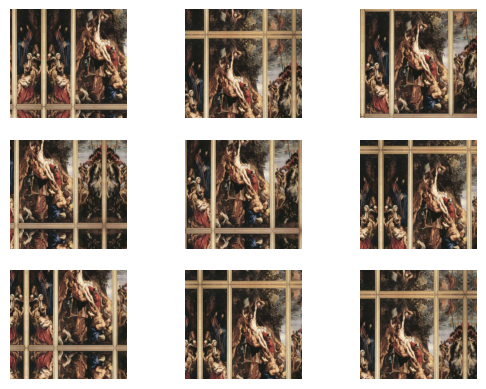

In [10]:
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Undersampled dataset

### Rubens en picasso

In [11]:
dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset"
# dataset_dir = "undersampled_dataset"
painters = ["Rubens", "Picasso"]
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height)

Found 310 files belonging to 2 classes.
Found 102 files belonging to 2 classes.
Found 102 files belonging to 2 classes.


#### Model trainen zonder data augmentation

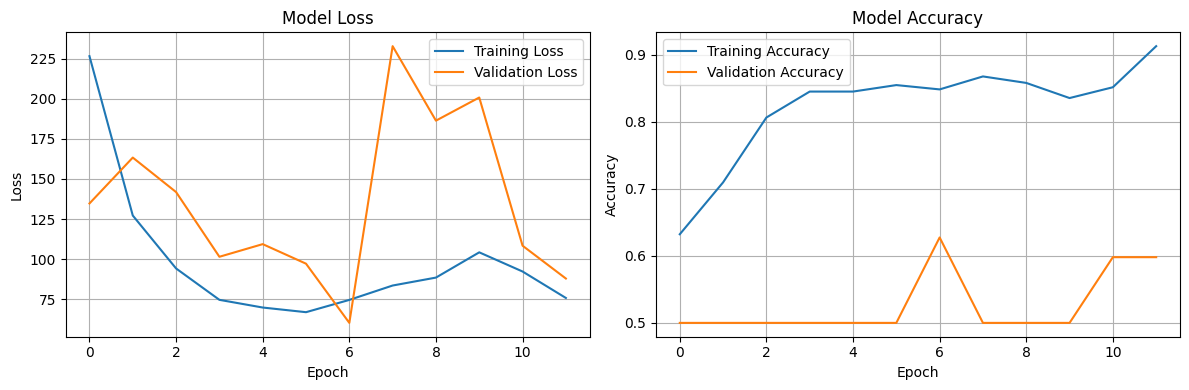

In [12]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Accuracy:  0.5294117647058824
Recall:  0.4117647058823529
Precision:  0.5384615384615384
F1:  0.4666666666666667


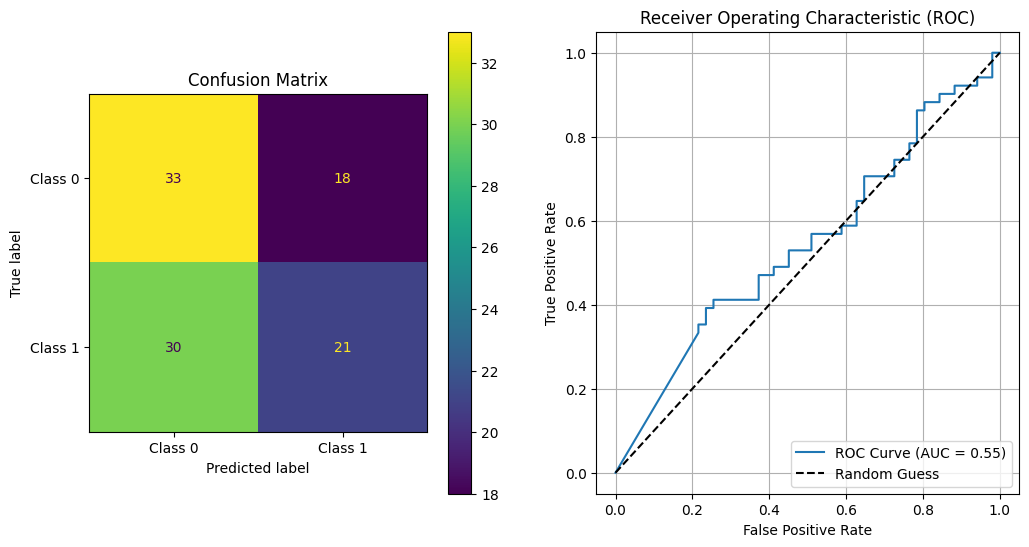

In [13]:
print_metrics(model, test)

#### Model trainen met data augmentation

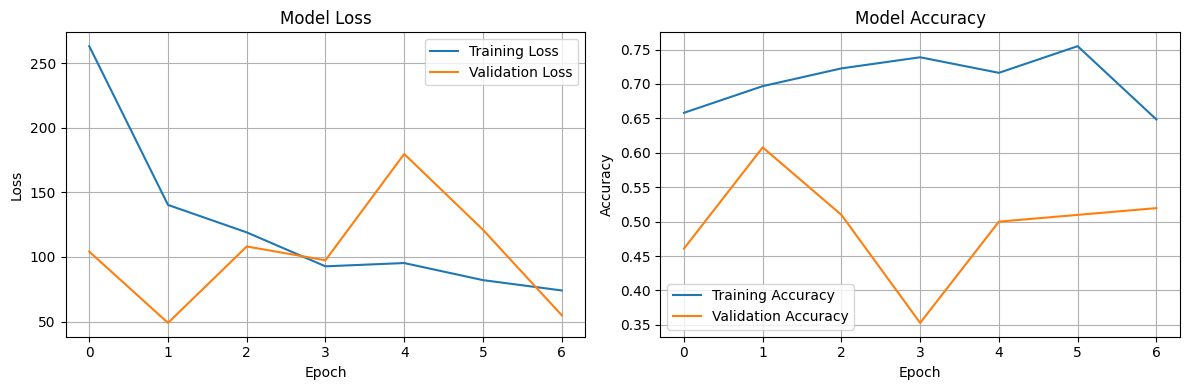

In [14]:
callbacks = [ModelCheckpoint(filepath="model_undersampled_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Accuracy:  0.6176470588235294
Recall:  0.45098039215686275
Precision:  0.6764705882352942
F1:  0.5411764705882354


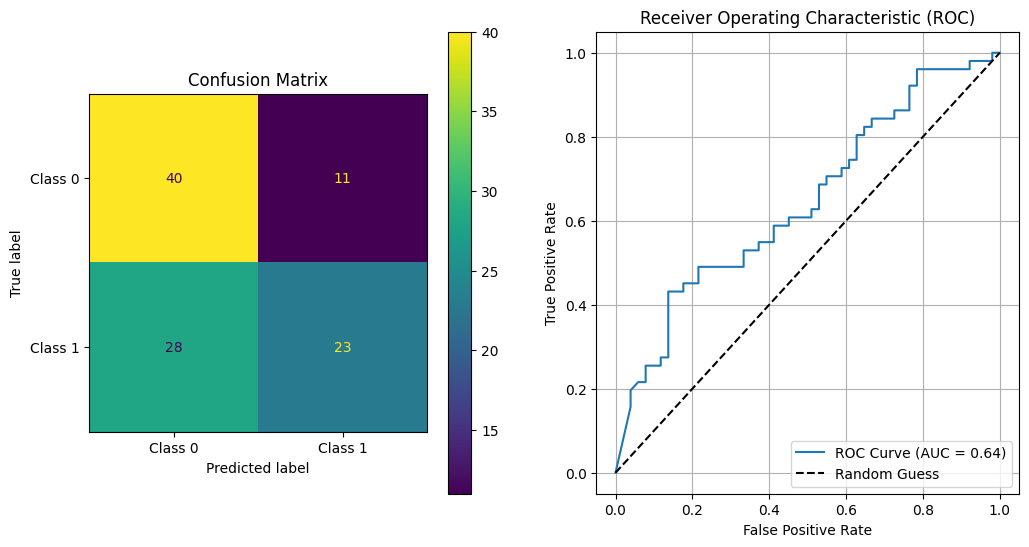

In [15]:
print_metrics(model, test)

### Mondriaan en Rubens

In [16]:
dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset"
# dataset_dir = "undersampled_dataset"
painters = ["Mondriaan", "Rubens"]
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height)

Found 310 files belonging to 2 classes.
Found 102 files belonging to 2 classes.
Found 102 files belonging to 2 classes.


#### Model trainen zonder data augmentation

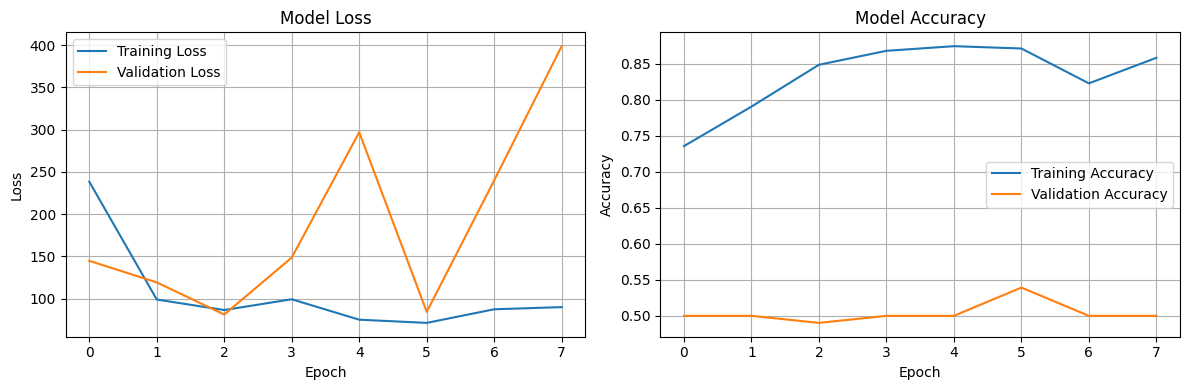

In [17]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Accuracy:  0.5196078431372549
Recall:  0.9803921568627451
Precision:  0.5102040816326531
F1:  0.6711409395973154


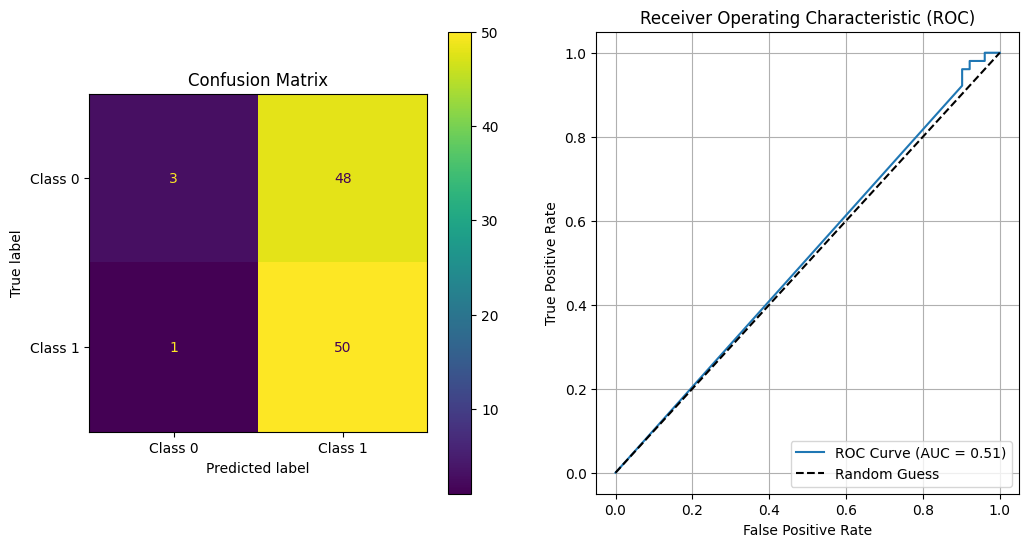

In [18]:
print_metrics(model, test)

#### Model trainen met data augmentation

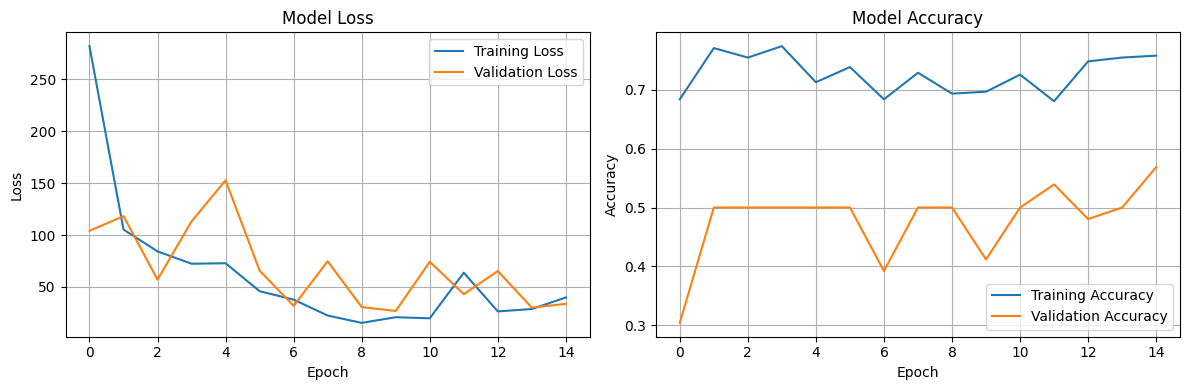

In [19]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Accuracy:  0.49019607843137253
Recall:  0.13725490196078433
Precision:  0.4666666666666667
F1:  0.21212121212121213


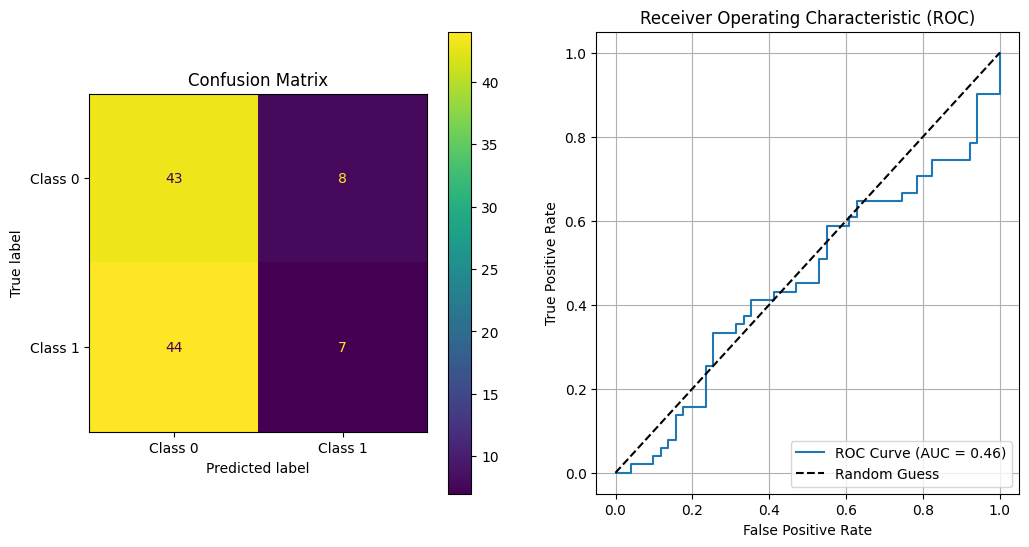

In [20]:
print_metrics(model, test)

## Oversampled dataset

### Rubens en picasso

In [21]:
# dataset_dir = "oversampled_dataset"
dataset_dir = "/kaggle/input/schilderijen-datasets/oversampled_dataset"
painters = ["Rubens", "Picasso"]
train, val, test = load_dataset(dataset_dir, painters, median_height, median_width, batch_size=16)

Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.


#### Model trainen zonder data augmentation

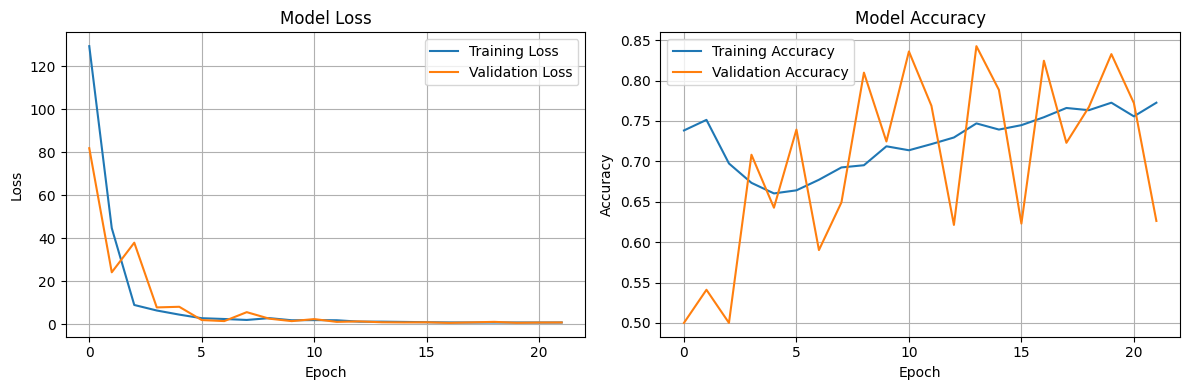

In [22]:
callbacks = [ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step
Accuracy:  0.45081967213114754
Recall:  0.3770491803278688
Precision:  0.4423076923076923
F1:  0.4070796460176991


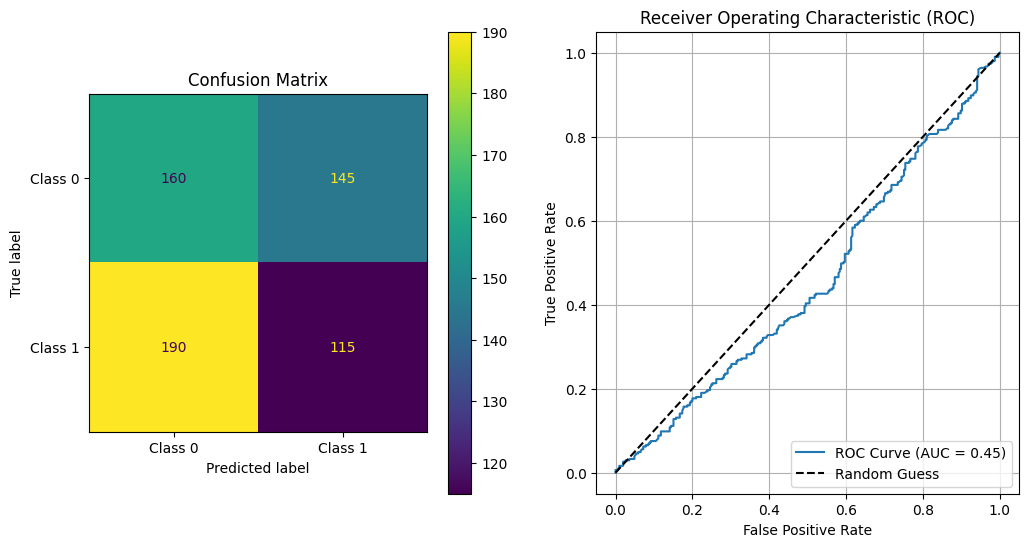

In [23]:
print_metrics(model, test)

#### Model trainen met data augmentation

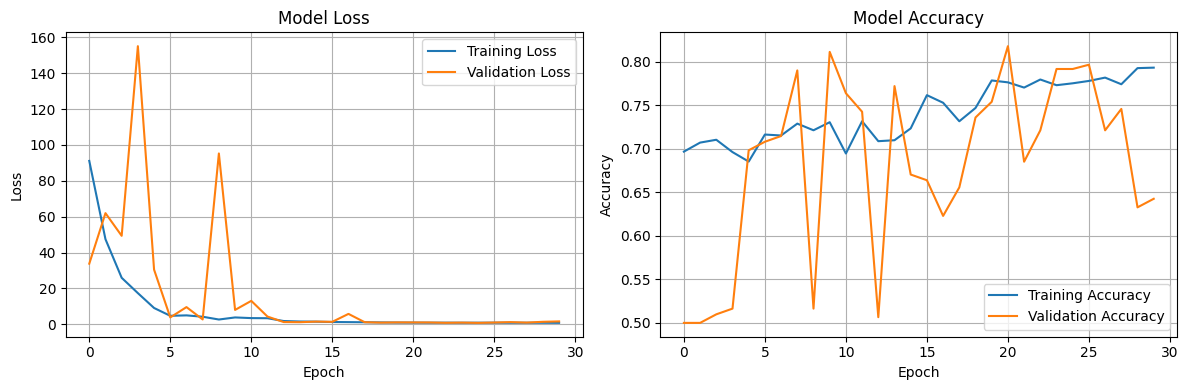

In [24]:
callbacks = [ModelCheckpoint(filepath="model_oversampled_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
Accuracy:  0.4819672131147541
Recall:  0.3016393442622951
Precision:  0.4717948717948718
F1:  0.36800000000000005


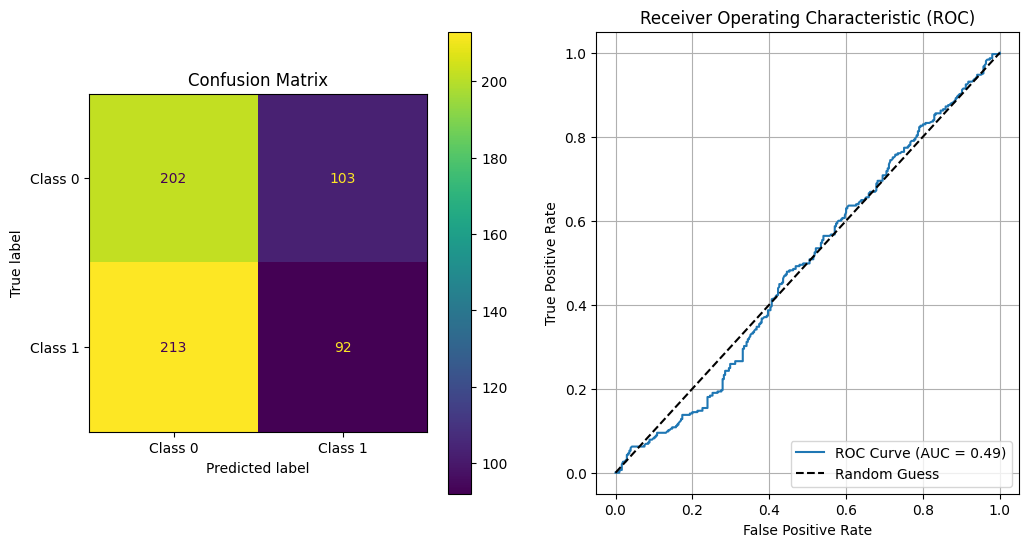

In [25]:
print_metrics(model, test)

### Mondriaan en Rembrandt

In [9]:
# dataset_dir = "oversampled_dataset"
dataset_dir = "/kaggle/input/schilderijen-datasets/oversampled_dataset"
painters = ["Mondriaan", "Rembrandt"]
train, val, test = load_dataset(dataset_dir, painters, median_height, median_width, batch_size=16)

Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.


#### Model trainen zonder data augmentation

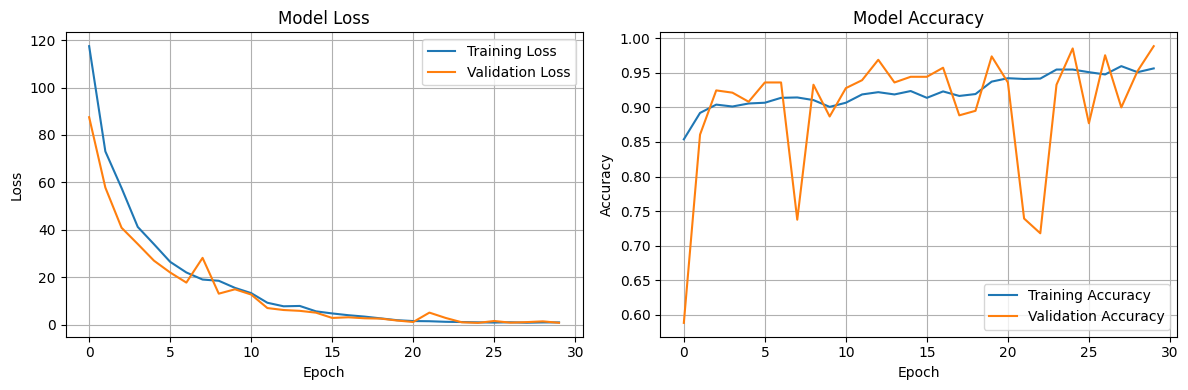

In [27]:
callbacks = [ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step
Accuracy:  0.5131147540983606
Recall:  0.5442622950819672
Precision:  0.5123456790123457
F1:  0.5278219395866456


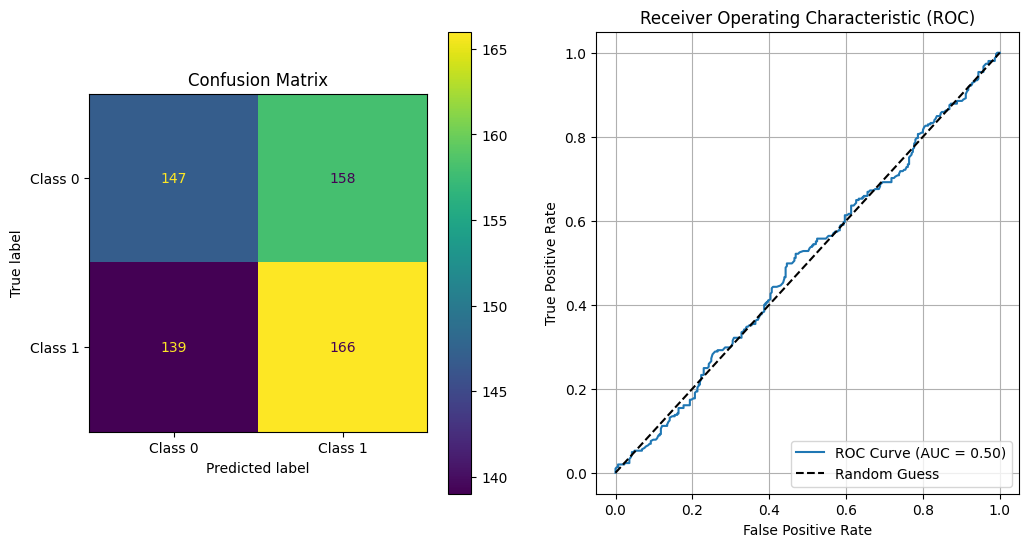

In [28]:
print_metrics(model, test)

#### Model trainen met data augmentation

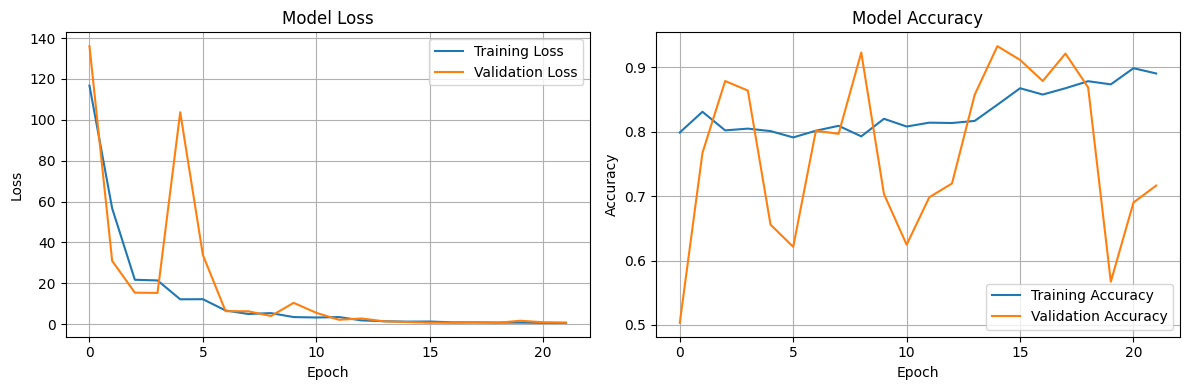

In [10]:
callbacks = [ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step
Accuracy:  0.49836065573770494
Recall:  0.6065573770491803
Precision:  0.49865229110512127
F1:  0.5473372781065089


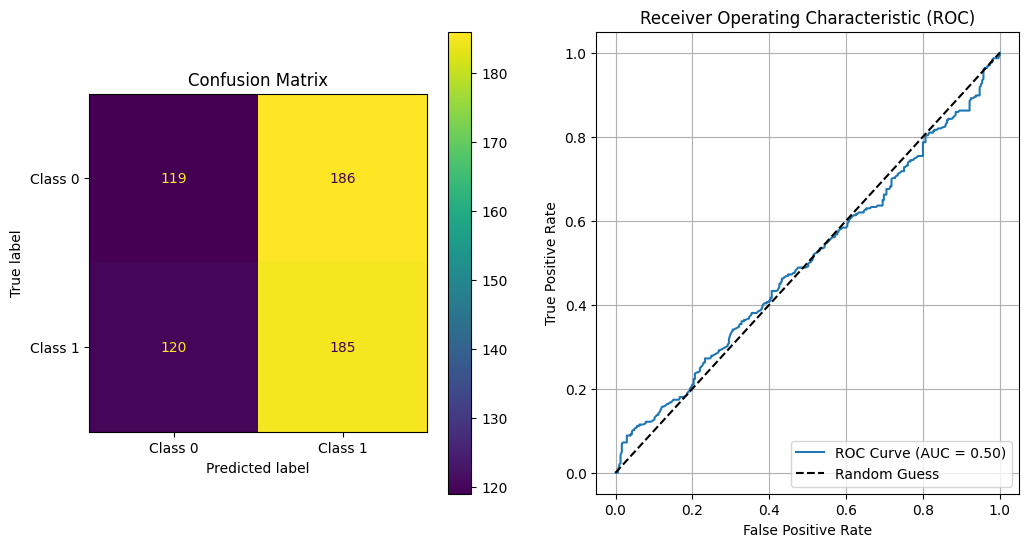

In [11]:
print_metrics(model, test)

## Imbalanced dataset

In [12]:
# dataset_dir = "imbalanced_dataset"
dataset_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset"
painters = ["Rubens", "Picasso"]
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height, batch_size=16)

Found 1323 files belonging to 2 classes.
Found 444 files belonging to 2 classes.
Found 440 files belonging to 2 classes.


### Rubens en picasso

#### Class weights bepalen

In [13]:
train.class_names

['Rubens', 'Picasso']

In [14]:
class_counts = {}

for _, labels in train:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total = sum(class_counts.values())
total, class_counts

(1323, {0: 406, 1: 917})

In [15]:
rubens_count = class_counts.get(0, 0)  
picasso_count = class_counts.get(1, 0)   

weight_for_0 = float((1 / rubens_count) * (total / 2.0)) if rubens_count > 0 else 0
weight_for_1 = float((1 / picasso_count) * (total / 2.0)) if picasso_count > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight

{0: 1.6293103448275863, 1: 0.7213740458015268}

#### Baseline

In [16]:
picasso_count / total

0.6931216931216931

#### Model trainen zonder data augmentation

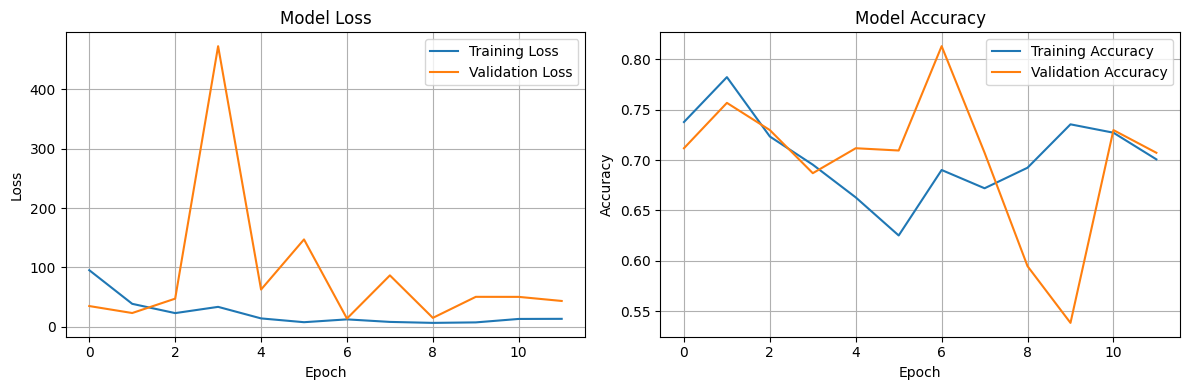

In [17]:
callbacks = [ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step
Accuracy:  0.5636363636363636
Recall:  0.7081967213114754
Precision:  0.677115987460815
F1:  0.6923076923076922


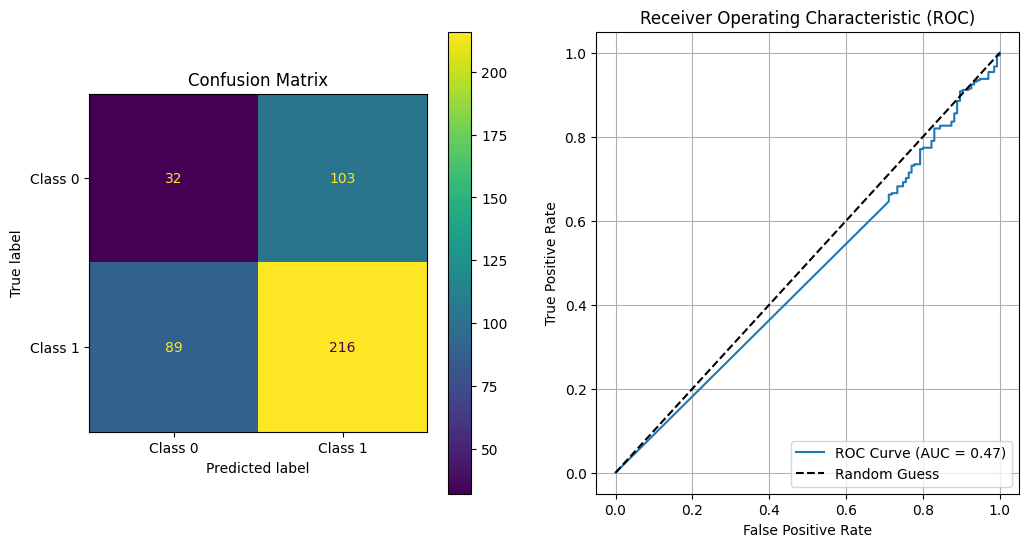

In [18]:
print_metrics(model, test)

#### Model trainen met data augmentation

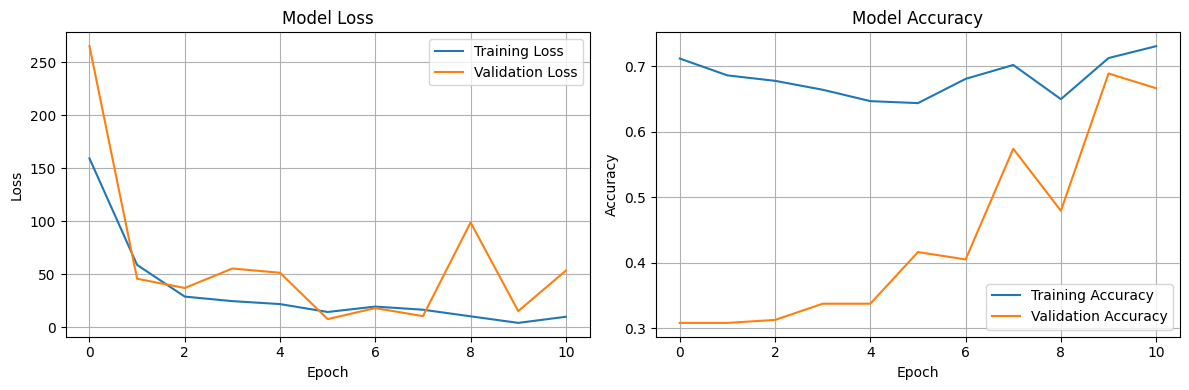

In [19]:
callbacks = [ModelCheckpoint(filepath="model_imbalanced_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
Accuracy:  0.3704545454545455
Recall:  0.14098360655737704
Precision:  0.7413793103448276
F1:  0.2369146005509642


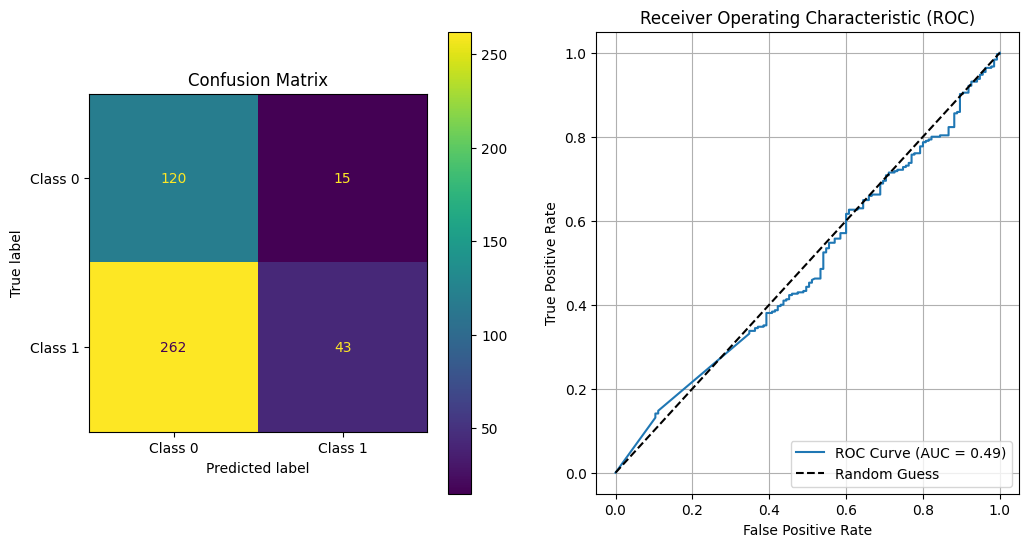

In [20]:
print_metrics(model, test)

### Mondriaan en Rembrandt

#### Data inladen

In [21]:
painters = ["Mondriaan", "Rembrandt"]
dataset_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset"
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height, batch_size=16)

Found 354 files belonging to 2 classes.
Found 118 files belonging to 2 classes.
Found 118 files belonging to 2 classes.


#### Class weights bepalen

In [22]:
class_counts = {}

for _, labels in train:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total = sum(class_counts.values())
total, class_counts

(354, {0: 198, 1: 156})

In [23]:
mondriaan_count = class_counts.get(0, 0)  
rembrandt_count = class_counts.get(1, 0)   

weight_for_0 = float((1 / mondriaan_count) * (total / 2.0)) if mondriaan_count > 0 else 0
weight_for_1 = float((1 / rembrandt_count) * (total / 2.0)) if rembrandt_count > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight

{0: 0.893939393939394, 1: 1.1346153846153846}

#### Baseline

In [24]:
mondriaan_count / total

0.559322033898305

#### Model trainen zonder data augmentatie

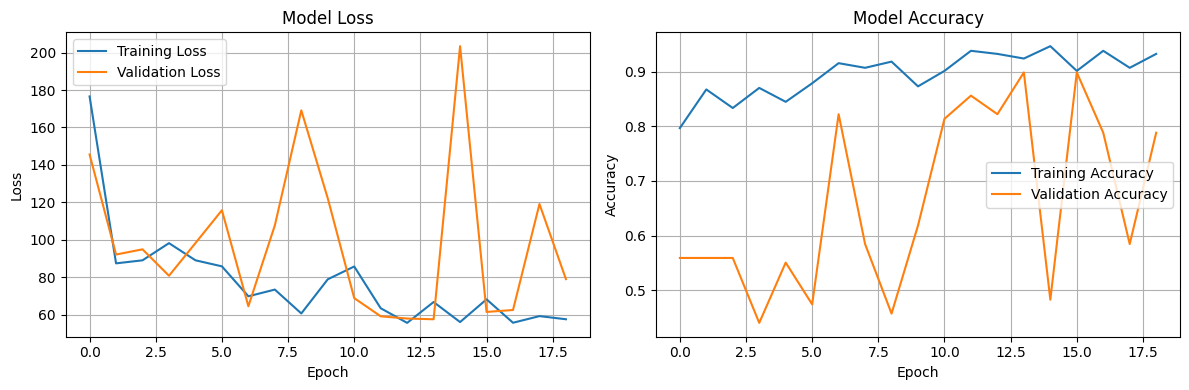

In [25]:
callbacks = [ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Accuracy:  0.5338983050847458
Recall:  0.4807692307692308
Precision:  0.4716981132075472
F1:  0.4761904761904762


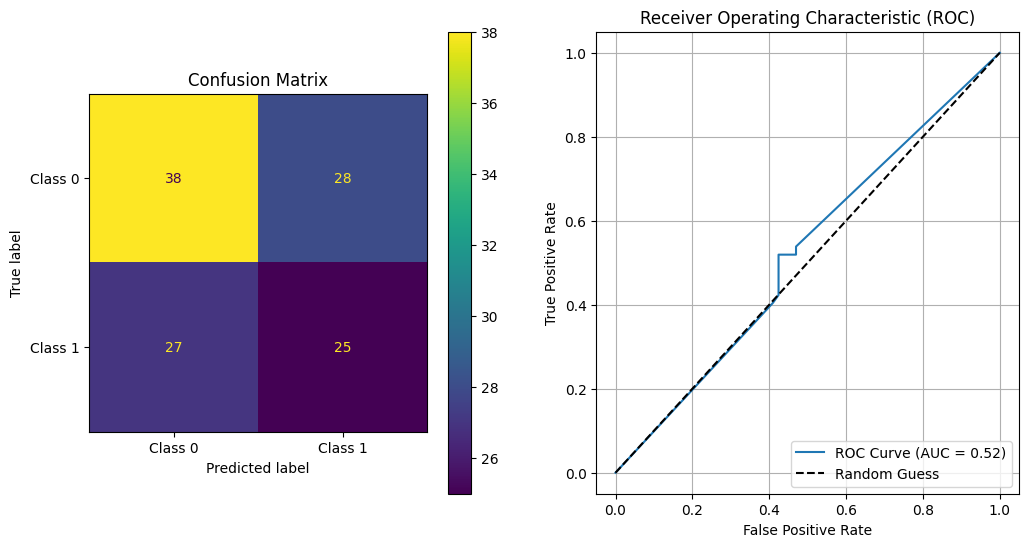

In [26]:
print_metrics(model, test)

#### Model trainen met data augmentatie

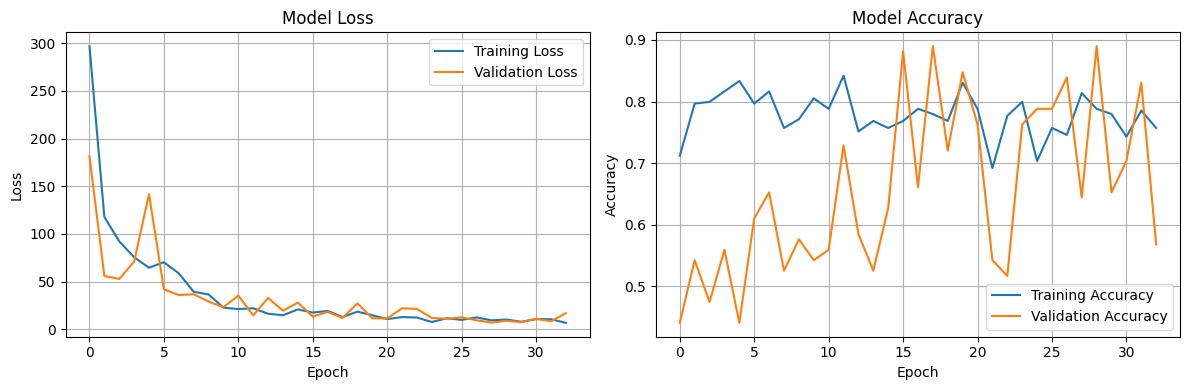

In [29]:
callbacks = [ModelCheckpoint(filepath="model_imbalanced_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Accuracy:  0.5169491525423728
Recall:  0.9038461538461539
Precision:  0.47474747474747475
F1:  0.6225165562913907


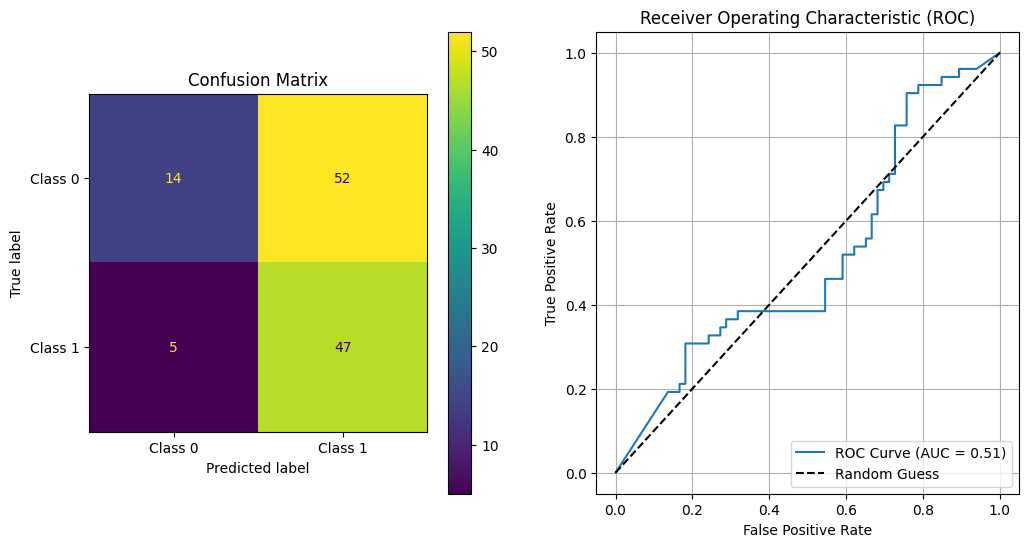

In [30]:
print_metrics(model, test)

## Image size bepalen

In [6]:
def run_grid_search(statistic, dataset_dir, painters, interpolations, subset_fraction=1):
    results = []

    width = int(stats.loc[f"{statistic}", "widths"])
    height = int(stats.loc[f"{statistic}", "heights"])
    
    for interpolation in interpolations:
        print(f"Processing {statistic} with interpolation: {interpolation}")

        train, val, test = load_dataset(dataset_dir, painters, width, height, batch_size=16, interpolation=interpolation, subset_fraction=subset_fraction)

        model = build_model(width, height)
        model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

        callbacks = [
            keras.callbacks.ModelCheckpoint(filepath="gridsearch_model.keras", save_best_only=True, monitor="val_loss"),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        ]
        
        history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

        y_pred_prob = model.predict(test)
        y_pred = np.where(y_pred_prob > 0.5, 1, 0)
        y_true = np.concatenate([y.numpy() for _, y in test], axis=0)

        test_accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=1)
        recall = recall_score(y_true, y_pred, zero_division=1)
        f1 = f1_score(y_true, y_pred, zero_division=1)
        auc_score = roc_auc_score(y_true, y_pred_prob)

        results.append({
            "statistic": statistic,
            "interpolation": interpolation,
            "width": width,
            "height": height,
            "epochs": len(history.history['accuracy']),
            "train_accuracy": history.history['accuracy'][-1],
            "val_accuracy": history.history['val_accuracy'][-1],
            "test_accuracy": test_accuracy,
            "train_loss": history.history['loss'][-1],
            "val_loss": history.history['val_loss'][-1],
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "auc": auc_score
        })

        print(results[-1]) 

    df = pd.DataFrame(results)
    return df


In [34]:
interpolations = ["bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5", "gaussian"]
dataset_dir = "/kaggle/input/schilderijen-datasets/oversampled_dataset"
painters = ["Mondriaan", "Picasso"]

results_min = run_grid_search("min", dataset_dir, painters, interpolations)
results_25 = run_grid_search("25%", dataset_dir, painters, interpolations)

Processing min with interpolation: bilinear
Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
{'statistic': 'min', 'interpolation': 'bilinear', 'width': 106, 'height': 108, 'epochs': 28, 'train_accuracy': 0.9492911696434021, 'val_accuracy': 0.7885245680809021, 'test_accuracy': 0.5295081967213114, 'train_loss': 0.6894765496253967, 'val_loss': 1.0014861822128296, 'precision': 0.53125, 'recall': 0.5016393442622951, 'f1_score': 0.5160202360876897, 'auc': 0.5311690405804891}
Processing min with interpolation: nearest
Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
{'statistic': 'min', 'interpolation': 'nearest', 'width': 106, 'height': 108, 'epochs': 23, 'train_accuracy': 0.94547438621521, 'val_accuracy': 0.7737705111503601, 'test_accuracy': 0.5360655737704918, 'train_lo

In [35]:
results_min.to_csv("image_size_gridsearch_result_min.csv")
results_25.to_csv("image_size_gridsearch_result_25.csv")

In [7]:
interpolations = ["bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5"]
dataset_dir = "/kaggle/input/schilderijen-datasets/oversampled_dataset"
painters = ["Mondriaan", "Picasso"]

results_mean = run_grid_search("mean", dataset_dir, painters, interpolations)
results_mean.to_csv("image_size_gridsearch_result_mean.csv")
results_median = run_grid_search("median", dataset_dir, painters)
results_median.to_csv("image_size_gridsearch_result_median.csv")
results_75 = run_grid_search("75%", dataset_dir, painters)
results_75.to_csv("image_size_gridsearch_result_75.csv")

Processing mean with interpolation: bilinear
Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
{'statistic': 'mean', 'interpolation': 'bilinear', 'width': 603, 'height': 648, 'epochs': 24, 'train_accuracy': 0.9182115793228149, 'val_accuracy': 0.7442622780799866, 'test_accuracy': 0.5032786885245901, 'train_loss': 1.2968090772628784, 'val_loss': 1.9186997413635254, 'precision': 0.5029239766081871, 'recall': 0.5639344262295082, 'f1_score': 0.5316846986089645, 'auc': 0.5030744423542058}
Processing mean with interpolation: nearest
Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
{'statistic': 'mean', 'interpolation': 'nearest', 'width': 603, 'height': 648, 'epochs': 43, 'train_accuracy': 0.9498364329338074, 'val_accuracy': 0.688524603843689, 'test_accuracy': 0.47049180327

TypeError: run_grid_search() missing 1 required positional argument: 'interpolations'

In [9]:
interpolations = ["bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5"]
dataset_dir = "/kaggle/input/schilderijen-datasets/oversampled_dataset"
painters = ["Mondriaan", "Picasso"]

results_median = run_grid_search("mean", dataset_dir, painters, interpolations)
results_median.to_csv("image_size_gridsearch_result_median.csv")
results_75 = run_grid_search("mean", dataset_dir, painters, interpolations)
results_75.to_csv("image_size_gridsearch_result_75.csv")

Processing mean with interpolation: bilinear
Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-9-be3a36d25e3a>", line 5, in <cell line: 5>

  File "<ipython-input-7-ce9b02c7ce12>", line 20, in run_grid_search

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 3509010464 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_80237]

In [ ]:
df.sort_values("test_accuracy", ascending=False).head(5)

In [ ]:
df.sort_values("f1_score", ascending=False).head(5)

In [ ]:
df.sort_values("precision", ascending=False).head(5)

In [ ]:
df.sort_values("recall", ascending=False).head(5)

In [ ]:
df.sort_values("val_loss").head(5)

In [ ]:
df.to_csv("image_size_gridsearch_result.csv")